# Citi Bike NYC por Daniel Miranda :)
Olá! O objetivo desse notebook é de explorar as bases disponiblizadas do Citi Bike NYC, que podem ser encontradas [aqui](https://data.world/citibikenyc/).
<br>
Para abordar de uma forma sistemática, a divisão desse projeto analítico será nas seguintes etapas:
<br>
- Contexto;
- Pegando os dados;
- Análise exploratória;
- Preparação dos dados para a modelagem;
- Modelagem e otimização;
- Desfecho e recomendações futuras;

## 1. Contexto
A Citi Bike NYC trabalha com o compartilhamento de bicicletas pela cidade de NY e disponibilizou gratuitamente seus dados de uso para eventuais análises.
Dessa forma, vamos usar esses dados para **buscar insights que possam alavancar o negócio**, assim como **criar um modelo para prever a utilização das bicicletas**.
<br>
<br>
Os insights têm como objetivo principal gerar discussões e recomendações para o negócio, enquanto a modelagem da utilização das bicicletas pode impactar algumas rotinas da  Citi Bike NYC:
- Otimização no headcount de equipes operacionais (externas e internas);
- Acuracidade no planejamento do orçamento;
- Estimar crescimento para que haja recursos suficientes para os clientes;

## 2. Pegando os dados

#### 2.1 Trip Data

A primeira base de trabalho nos fornece dados de cada viagem, incluindo: tempo de uso, datas de início e término, estações de início e de fim (assim como latitude/longitude), tipo de cliente, gênero e idade.
<br>
Para uma boa parte da nossa exploração e modelagem, **vamos tratar a base para consolidar o uso por hora de cada dia**.
<br>
Usaremos as bases entre **Janeiro e Dezembro de 2017**.
<br>
#### 2.2 Clima

Para enriquecer as nossas análises, buscamos os dados de clima disponíveis pelo [National Center for Environmental Information](https://www.ncdc.noaa.gov/). Nossa referência aqui foi buscar a estação meteorológica do Central Park e **de hora em hora**. O objetivo é usar não só os histórico de uso, mas também **o impacto do clima no uso das bicicletas**.
<br>
Os dados foram recebidos via FTP:
<br>
#### 2.3 Feriados

Da mesma forma, vamos enriquecer nossa base com os feriados para entender o impacto na operação. Os dados foram obtidos no [Office Holidays.com](https://www.officeholidays.com/countries/usa/new-york/2017) e apenas considerados os feriados federais e locais.

In [1]:
#Como estou usando um notebook que não pode performar esse volume, vou usar o dask para programação paralela
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")

data_01 = dd.read_csv('201701-citibike-tripdata.csv')
data_02 = dd.read_csv('201702-citibike-tripdata.csv')
data_03 = dd.read_csv('201703-citibike-tripdata.csv')
data_04 = dd.read_csv('201704-citibike-tripdata.csv')
data_05 = dd.read_csv('201705-citibike-tripdata.csv')
data_06 = dd.read_csv('201706-citibike-tripdata.csv')
data_07 = dd.read_csv('201707-citibike-tripdata.csv')
data_08 = dd.read_csv('201708-citibike-tripdata.csv')
data_09 = dd.read_csv('201709-citibike-tripdata.csv')
data_10 = dd.read_csv('201710-citibike-tripdata.csv')
data_11 = dd.read_csv('201711-citibike-tripdata.csv')
data_12 = dd.read_csv('201712-citibike-tripdata.csv')

In [2]:
#Observei que os três primeiros meses contam com um padrão diferente de colunas, aqui vamos renomear

new_columns = ['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender']

data_01 = data_01.rename(columns=dict(zip(data_01.columns, new_columns)))
data_02 = data_02.rename(columns=dict(zip(data_02.columns, new_columns)))
data_03 = data_03.rename(columns=dict(zip(data_03.columns, new_columns)))

In [3]:
#Feito isso, vamos concatenar o um ano de dados
data_full = dd.concat([data_01,data_02,data_03,data_04,data_05,data_06,data_07,data_08,data_09,data_10,data_11,data_12], interleave_partitions=True)

In [4]:
#Aqui, manipulamos as datas para consolidar
data_full['Year'] = data_full['starttime'].str[:4]
data_full['Month'] = data_full['starttime'].str[5:7]
data_full['Day'] = data_full['starttime'].str[8:10]
data_full['Hour'] = data_full['starttime'].str[11:13]

In [5]:
#Aqui, começamos a manipular por tipo de cliente
data_full_subscriber = data_full[data_full['usertype'] == 'Subscriber']
data_full_customer = data_full[data_full['usertype'] == 'Customer']

In [6]:
#Manipulando a base em células diferentes apenas para uma questão de performance
data_full_subscriber_by_day = data_full_subscriber.groupby(['Month','Day','Hour']).count().compute()

In [7]:
#Idem, apenas indo para a parte 2
data_full_customer_by_day = data_full_customer.groupby(['Month','Day','Hour']).count().compute()

In [8]:
#Concluímos a primeira etapa de tratamento
import pandas as pd

data_full_by_type = pd.merge(data_full_subscriber_by_day['tripduration'],data_full_customer_by_day['tripduration'], left_index = True, right_index = True, how = 'left')
data_full_by_type = data_full_by_type.fillna(0)
data_full_by_type.rename(columns={'tripduration_x':'Subscribers','tripduration_y':'Customers'}, inplace = True)
data_full_by_type['Total'] = data_full_by_type['Subscribers'] + data_full_by_type['Customers']

In [9]:
#Aqui, vamos trabalhar a base de temperatura de Nova York. Como é uma base pequena, vamos seguir direto com Pandas
weather = pd.read_fwf('weather-nyc.txt')
weather['YR--MODAHRMN'] = weather['YR--MODAHRMN'].astype(str)

weather['Data Completa'] = pd.to_datetime(weather['YR--MODAHRMN'], format= '%Y%m%d%H%M')

#Precisamos corrigir a nossa data, pois está em GMT e precisamos diminuir 5 horas por conta do fuso de NY
time_delta = pd.Timedelta(hours=5)
weather['Data Corrigida'] = (weather['Data Completa'] - time_delta)

#Aqui aproveitamos e tiramos o dia da semana
weather['Dia Semana'] = weather['Data Corrigida'].dt.weekday

#Vamos incluir o dia da semana
dia_da_semana = {0:'Segunda',1:'Terca',2:'Quarta',3:'Quinta',4:'Sexta',5:'Sábado',6:'Domingo'}
weather['Dia da Semana'] = weather['Dia Semana'].map(dia_da_semana)

#Ajustando datas para concatenar com o restante da base
weather['Data Corrigida'] = weather['Data Corrigida'].astype(str)
weather['Ano'] = weather['Data Corrigida'].str[0:4]
weather['Month'] = weather['Data Corrigida'].str[5:7]
weather['Day'] = weather['Data Corrigida'].str[8:10]
weather['Hour'] = weather['Data Corrigida'].str[11:13]

#Filtrando apenas anos de 2017.
weather_nyc = weather[weather['Ano'] == '2017']

#Vamos pegar alguns dados que são relevantes
weather_nyc['Chuva'] = weather['PCP01 PCP06 PCP24 PCPXX SD'].str[:4]
weather_nyc['Neve'] = weather['PCP01 PCP06 PCP24 PCPXX SD'].str[23:]

columns = ['Month','Day','Hour','Dia da Semana','Chuva','Neve','CLG','SKC','TEMP','DEWP']

weather_nyc_final = weather_nyc[columns].set_index(['Month','Day','Hour'])

In [10]:
#Agora vamos juntar a base de clientes com a base de clima para um tratamento final de valores faltantes
final_data_set = pd.merge(data_full_by_type,weather_nyc_final, left_index = True, right_index = True, how = 'left')

#Aqui estamos removendo os dados após as 18h, pois não temos nenhum valor climático
data_set = final_data_set.iloc[:11453]

#Aqui trabalhamos com os números faltantes. Em relação á neve, zeramos, assim como a Chuva
#SKC trabalhará com o valor mais frequente, e temperatura/DEWP entrará com a média

import numpy as np

data_set['Neve'] = data_set['Neve'].replace('**',0)
data_set['Neve'] = data_set['Neve'].replace(' **',0)
data_set['SKC'] = data_set['SKC'].replace('***','CLR')
data_set['Chuva'] = data_set['Chuva'].replace('****',0)
data_set['CLG'] = data_set['CLG'].replace('***','722')

data_set['TEMP'] = data_set['TEMP'].replace('****',np.nan).astype('float64')
media_temp = np.sum(data_set['TEMP'])/len(data_set['TEMP'])
data_set['TEMP'] = data_set['TEMP'].replace(np.nan,media_temp)

data_set['DEWP'] = data_set['DEWP'].replace('****',np.nan).astype('float64')
media_dewp = np.sum(data_set['DEWP'])/len(data_set['DEWP'])
data_set['DEWP'] = data_set['DEWP'].replace(np.nan,media_dewp)
#Temos a falta de um dado de clima, vamos remove-lo da nossa base
data_set = data_set.drop(('09','12','14'))

In [11]:
#Nossa última base vamos construir manualmente com os feriados
hours = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

#Feriado 1 = 02 de janeiro

feriado1 = pd.DataFrame(hours)
feriado1['Month'] = '01'
feriado1['Day'] = '02'

#Feriado 2 = 16 de janeiro
feriado2 = pd.DataFrame(hours)
feriado2['Month'] = '01'
feriado2['Day'] = '16'

#Feriado 3 = 20 de fevereiro
feriado3 = pd.DataFrame(hours)
feriado3['Month'] = '02'
feriado3['Day'] = '20'

#Feriado 4 = 29 de maio
feriado4 = pd.DataFrame(hours)
feriado4['Month'] = '05'
feriado4['Day'] = '29'

#Feriado 5 = 04 de julho
feriado5 = pd.DataFrame(hours)
feriado5['Month'] = '07'
feriado5['Day'] = '04'

#Feriado 6 = 04 de setembro
feriado6 = pd.DataFrame(hours)
feriado6['Month'] = '09'
feriado6['Day'] = '04'

#Feriado 7 = 09 de outubro
feriado7 = pd.DataFrame(hours)
feriado7['Month'] = '10'
feriado7['Day'] = '09'

#Feriado 8 = 10 de novembro
feriado8 = pd.DataFrame(hours)
feriado8['Month'] = '11'
feriado8['Day'] = '10'

#Feriado 9 = 23 de novembro
feriado9 = pd.DataFrame(hours)
feriado9['Month'] = '11'
feriado9['Day'] = '23'

#Feriado 10 = 25 de dezembro
feriado10 = pd.DataFrame(hours)
feriado10['Month'] = '12'
feriado10['Day'] = '25'

feriados = pd.concat([feriado1,feriado2,feriado3,feriado4,feriado5,feriado6,feriado7,feriado8,feriado9,feriado10])
feriados['Feriado'] = 1
feriados.rename(columns={0:'Hour'}, inplace = True)
lista_de_feriados = feriados.set_index(['Month','Day','Hour'])

#Juntando os nossos feriados na base e ajustando os tipos de variáveis
data_set_final = pd.merge(data_set, lista_de_feriados, left_index = True, right_index = True, how = 'left')
data_set_final['Feriado'] = data_set_final['Feriado'].replace(np.nan,0)
data_set_final['Customers'] = data_set_final['Customers'].astype('int64')
data_set_final['Total'] = data_set_final['Total'].astype('int64')
data_set_final['Chuva'] = data_set_final['Chuva'].astype('float64')
data_set_final['Neve'] = data_set_final['Neve'].astype('float64')
data_set_final['TEMP'] = data_set_final['TEMP'].astype('int64')
data_set_final['DEWP'] = data_set_final['DEWP'].astype('int64')
data_set_final['Feriado'] = data_set_final['Feriado'].astype('object')

In [12]:
#Agora temos uma base para começar a trabalhar na exploração
data_set_final

#A seguir, apenas a demontração da redução da nossa base de 16 MM

Subscribers  Customers  Total Dia da Semana  Chuva  Neve  CLG  \
Month Day Hour                                                                  
01    01  00            295         58    353       Domingo    0.0   0.0   55   
          01            316         34    350       Domingo    0.0   0.0   80   
          02            256         24    280       Domingo    0.0   0.0   55   
          03            180         26    206       Domingo    0.0   0.0  722   
          04             87          9     96       Domingo    0.0   0.0   50   
...                     ...        ...    ...           ...    ...   ...  ...   
12    31  14            573         31    604       Domingo    0.0   0.0  110   
          15            574         14    588       Domingo    0.0   0.0  722   
          16            510         17    527       Domingo    0.0   0.0  722   
          17            398         11    409       Domingo    0.0   0.0  722   
          18            320         26    346       Domingo    0.0   0.0  722   

                SKC  TEMP  DEWP Feriado  
Month Day Hour                           
01    01  00    CLR    44    25       0  
          01    CLR    44    26       0  
          02    CLR    45    25       0  
          03    SCT    44    25       0  
          04    CLR    45    24       0  
...             ...   ...   ...     ...  
12    31  14    CLR    15    -4       0  
          15    SCT    14    -5       0  
          16    CLR    13    -5       0  
          17    CLR    13    -5       0  
          18    CLR    12    -5       0  

[11452 rows x 11 columns]

## 3. Análise Exploratória


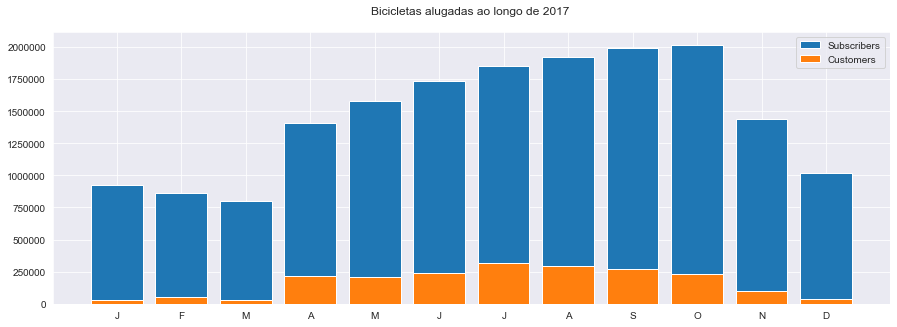

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize=(15,5))
plt.bar(range(len(data_set_final.groupby('Month').count()['Subscribers'])),data_set_final.reset_index().groupby('Month').sum()['Subscribers'], label = 'Subscribers')
plt.bar(range(len(data_set_final.groupby('Month').count()['Customers'])),data_set_final.reset_index().groupby('Month').sum()['Customers'], label = 'Customers')
plt.xticks(range(len(data_set_final.groupby('Month').count()['Total'])),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.title('Bicicletas alugadas ao longo de 2017 \n')
plt.legend()

Temos uma rampagem agressiva do primeiro para o segundo trimestre. A principal causa potencial para explorar é a estação do ano, especificamente porque de Dezembro a Março estamos falando do **inverno** no hemisfério norte.

Text(0.5, 1.0, 'Distribuição de Temperatura ao longo do ano de 2017 \n')

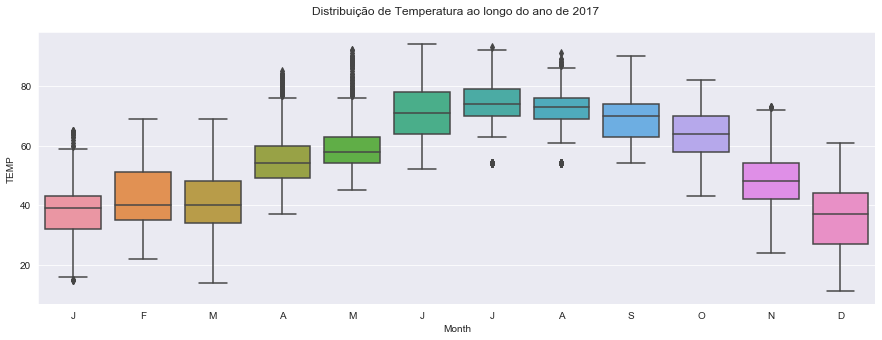

In [14]:
plt.figure(figsize=(15,5))
sns.boxplot(x='Month', y='TEMP', data=data_set_final.reset_index())
plt.xticks(range(len(data_set_final.groupby('Month').count()['Total'])),['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.title('Distribuição de Temperatura ao longo do ano de 2017 \n')

Aqui fortalecemos a hipótese do impacto da temperatura no uso das bicicletas, pois é possível perceber a diferença nos meses do inverno.
<br>
<br>
A primeira recomendação é a de **gerar incentivo para novos cadastros para experimentação antes do inverno** para suavizar essa diferença. Essa lacuna na utilização gera uma oportunidade para **novas parcerias para levar clientes potenciais para as bicicletas**.
<br>
<br>
Espera-se que as campanhas alavanquem o número de day-passes (customers), que reflitirá em inscritos (subscribers).

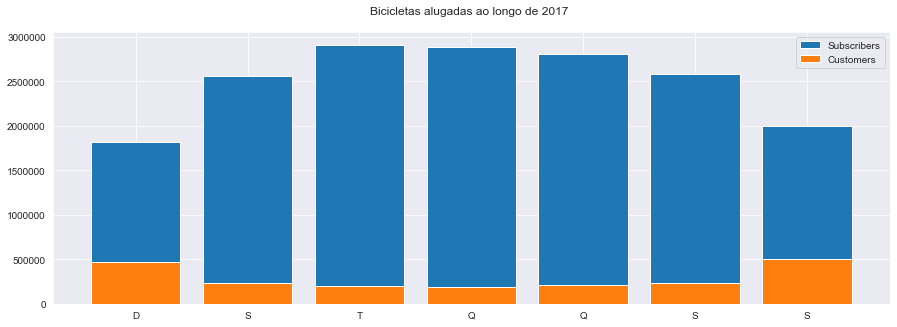

In [15]:
plt.figure(figsize=(15,5))
plt.bar(range(len(data_set_final.groupby('Dia da Semana').sum()['Subscribers'].reindex(['Domingo','Segunda','Terca','Quarta','Quinta','Sexta','Sábado']))),data_set_final.groupby('Dia da Semana').sum()['Subscribers'].reindex(['Domingo','Segunda','Terca','Quarta','Quinta','Sexta','Sábado']), label = 'Subscribers')
plt.bar(range(len(data_set_final.groupby('Dia da Semana').sum()['Customers'].reindex(['Domingo','Segunda','Terca','Quarta','Quinta','Sexta','Sábado']))),data_set_final.groupby('Dia da Semana').sum()['Customers'].reindex(['Domingo','Segunda','Terca','Quarta','Quinta','Sexta','Sábado']), label = 'Customers')
plt.xticks(range(len(data_set_final.groupby('Dia da Semana').sum()['Customers'])),['D','S','T','Q','Q','S','S'])
plt.title('Bicicletas alugadas ao longo de 2017 \n')
plt.legend()

O **final de semana é impactado** por um aumento de day-passes. Esse fato pode gerar uma oportunidade para produtos de longo prazo durante o final de semana para otimizar o LTV desse segmento de clientes.
<br>
Além disso, cabe uma chance de uma régua de relacionamento exclusiva para esse perfil de cliente com o objetivo de up-sell (possivelmente por meio do novo produto potencial citado).

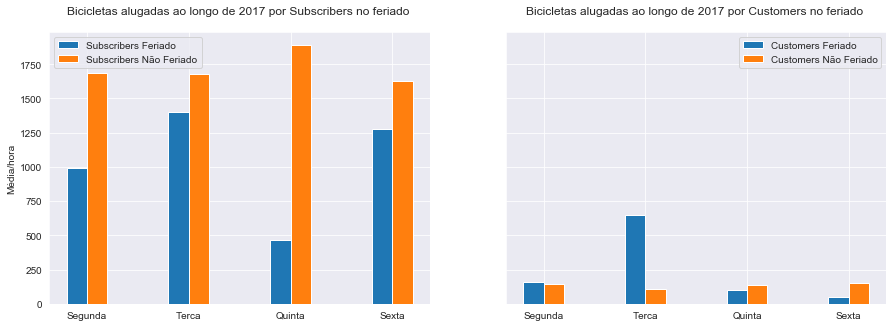

In [16]:
width = 0.2
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharey = True)
ax1.bar(range(len(data_set_final[data_set_final['Feriado'] == 1].groupby('Dia da Semana').mean()['Subscribers'].reindex(['Segunda','Terca','Quinta','Sexta']))),data_set_final[data_set_final['Feriado'] == 1].groupby('Dia da Semana').mean()['Subscribers'].reindex(['Segunda','Terca','Quinta','Sexta']), width = width, label = 'Subscribers Feriado')
ax1.bar([0.2,1.2,2.2,3.2],data_set_final[data_set_final['Feriado'] == 0].groupby('Dia da Semana').mean()['Subscribers'].reindex(['Segunda','Terca','Quinta','Sexta']), width = width, label = 'Subscribers Não Feriado')
ax1.set_xticks([0.1,1.1,2.1,3.1])
ax1.set_xticklabels(['Segunda','Terca','Quinta','Sexta'])
ax1.set_title('Bicicletas alugadas ao longo de 2017 por Subscribers no feriado \n')
ax1.set_ylabel('Média/hora')
ax1.legend()

ax2.bar(range(len(data_set_final[data_set_final['Feriado'] == 1].groupby('Dia da Semana').mean()['Customers'].reindex(['Segunda','Terca','Quinta','Sexta']))),data_set_final[data_set_final['Feriado'] == 1].groupby('Dia da Semana').mean()['Customers'].reindex(['Segunda','Terca','Quinta','Sexta']), width = width, label = 'Customers Feriado')
ax2.bar([0.2,1.2,2.2,3.2],data_set_final[data_set_final['Feriado'] == 0].groupby('Dia da Semana').mean()['Customers'].reindex(['Segunda','Terca','Quinta','Sexta']), width = width, label = 'Customers Não Feriado')
ax2.set_xticks([0.1,1.1,2.1,3.1])
ax2.set_xticklabels(['Segunda','Terca','Quinta','Sexta'])
ax2.set_title('Bicicletas alugadas ao longo de 2017 por Customers no feriado \n')
ax2.legend()

O comparativo de Subscribers aponta que o perfil de cliente parece indicar que os assinantes parecem usar o negócio como meio de transporte para o trabalho, e não em dias de lazer.
<br>
Isso pode indicar uma **oportunidade de planos para usuários que queiram usar eventualmente**, numa tentativa de up-sell para o day-pass.
<br>
Vale reforçar que o ano de 2017 contou com poucos feriados, o que pode impactar nessa percepção.

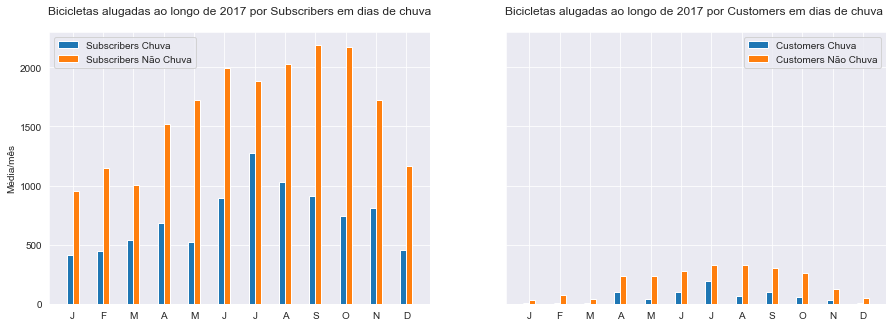

In [17]:
width = 0.2
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharey = True)
ax1.bar(range(len(data_set_final[data_set_final['Chuva'] > 0].groupby('Month').mean()['Subscribers'])),data_set_final[data_set_final['Chuva'] > 0].groupby('Month').mean()['Subscribers'], width = width, label = 'Subscribers Chuva')
ax1.bar([0.2,1.2,2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2,10.2,11.2],data_set_final[data_set_final['Chuva'] == 0].groupby('Month').mean()['Subscribers'], width = width, label = 'Subscribers Não Chuva')
ax1.set_xticks([0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1])
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax1.set_title('Bicicletas alugadas ao longo de 2017 por Subscribers em dias de chuva\n')
ax1.set_ylabel('Média/mês')
ax1.legend()

ax2.bar(range(len(data_set_final[data_set_final['Chuva'] > 0].groupby('Month').mean()['Customers'])),data_set_final[data_set_final['Chuva'] > 0].groupby('Month').mean()['Customers'], width = width, label = 'Customers Chuva')
ax2.bar([0.2,1.2,2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2,10.2,11.2],data_set_final[data_set_final['Chuva'] == 0].groupby('Month').mean()['Customers'], width = width, label = 'Customers Não Chuva')
ax2.set_xticks([0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,10.1,11.1])
ax2.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax2.set_title('Bicicletas alugadas ao longo de 2017 por Customers em dias de chuva \n')
ax2.legend()

Apesar do impacto evidente da chuva, **o mês mais quente do ano** - Junho - **tem uma similaridade de clientes com day-pass em dias de chuva e em dias secos**.
<br>
Isso nos leva a reflexão sobre eventuais campanhas mesmo em dias de chuva para alavancar o uso das bicicletas nesse mês.
<br>
Além disso, essa variável se mostrou mais uma vez útil quando formos fazer nosso modelo de propensão ao uso.

## 3. Preparação para modelagem
Vamos retomar que nosso objetivo aqui é de **criar um modelo de propensão da quantidade de bicicletas por dia e hora**.
<br>
Com isso, vamos ajustar nossa base para rodar alguns modelos e avaliar resultados

In [18]:
#Criamos uma cópia para a modelagem
data_set_modelo = data_set_final.reset_index()

#Selecionando apenas as variáveis que vão se modelar
X = data_set_modelo[['Month', 'Day', 'Hour',
       'Dia da Semana', 'Chuva', 'Neve', 'CLG', 'SKC', 'TEMP', 'DEWP',
       'Feriado']]

#Selecionando a variável alvo
y = data_set_modelo[['Total']]

In [19]:
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

#Meu primeiro passo é criar um custom transformer para apenas selecionar as colunas que desejo
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

#O segundo passo é direcionar as colunas de acordo com sua classificação
class SelectType(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X.select_dtypes(include = [self.dtype])

In [20]:
#Agora vamos criar um pipeline de dados para: escolher as colunas corretas do modelo,
#dividir a base de acordo com seu tipo,
#gerar variáveis binárias para colunas categorizadas,
#normalizar as variáveis numéricas.

from sklearn.pipeline import make_pipeline

preprocessing_pipeline = make_pipeline(
    ColumnSelector(columns=['Month', 'Day', 'Hour',
       'Dia da Semana', 'Chuva', 'Neve', 'CLG', 'SKC', 'TEMP', 'DEWP',
       'Feriado']),
    FeatureUnion(transformer_list = [
    ('Numbers', make_pipeline(
        SelectType(np.number), SimpleImputer(strategy='median'), StandardScaler())),
    ('Object', make_pipeline(
        SelectType('object'), SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown="ignore")))
])
)

**Por quê fizemos isso?**
<br>
Nosso objetivo é de gerar cross-validations ao longo da nossa base, com o objetivo de selecionar um modelo que seja estável e com **capacidade de generalizar o resultado em bases desconhecidas**.
<br>
<br>
O pipeline de dados garantirá que não haverá o evento de **vazamento de dados** entre as bases de teste e as bases de treino, e portanto teremos resultados mais confiáveis para decidir o modelo.

## 4. Modelagem e Otimização

<br>
Nossa métrica de avaliação escolhida para essa regressão é o RMSE.
<br>
<br>
Cada modelo a seguir passará por diferentes combinações de parâmetros para encontrar sua melhor performance.
<br>
Cada uma dessas combinações será analisada cinco vezes por bases divididas de formas diferentes, com o objetivo de aumentar a confiabilidade do nosso resultado.
<br>
<br>
Vamos para nosso primeiro modelo: Ridge Regression.

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

classifier_pipeline_ridge = make_pipeline(preprocessing_pipeline,
                                    Ridge()
)

param_grid = {"ridge__alpha": [0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 100]}

classifier_model_ridge = GridSearchCV(classifier_pipeline_ridge, param_grid, cv=5, scoring = 'neg_mean_squared_error')
classifier_model_ridge.fit(X,y)
classifier_model_ridge.best_score_

-906870.6560808584

Agora vamos para nosso segudo modelo: ***Lasso***.

In [22]:
from sklearn.linear_model import Lasso

classifier_pipeline_lasso = make_pipeline(preprocessing_pipeline,
                                      Lasso())

param_grid = {"lasso__alpha": [0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]}

classifier_model_lasso = GridSearchCV(classifier_pipeline_lasso, param_grid, cv=5, scoring = 'neg_mean_squared_error')
classifier_model_lasso.fit(X,y)
classifier_model_lasso.best_score_

-902843.0152884991

Vamos seguir para o nosso terceiro modelo: ***Kernel Ridge***.

In [23]:
from sklearn.kernel_ridge import KernelRidge

classifier_pipeline_krr = make_pipeline(preprocessing_pipeline,
                                      KernelRidge())

param_grid = {"kernelridge__alpha": [0.01, 0.1, 1, 10]}

classifier_model_krr = GridSearchCV(classifier_pipeline_krr, param_grid, cv=5, scoring = 'neg_mean_squared_error')
classifier_model_krr.fit(X,y)
classifier_model_krr.best_score_

-912159.0529186665

Próximo modelo: ***Random Forest***.

In [24]:
from sklearn.ensemble import RandomForestRegressor

classifier_pipeline_rf = make_pipeline(preprocessing_pipeline,
                                      RandomForestRegressor())

param_grid = {"randomforestregressor__max_depth": [2,3,4]}

classifier_model_rf = GridSearchCV(classifier_pipeline_rf, param_grid, cv=5, scoring = 'neg_mean_squared_error')
classifier_model_rf.fit(X,y)
classifier_model_rf.best_score_

-1872366.3937164024

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

classifier_pipeline_xg = make_pipeline(preprocessing_pipeline,
GradientBoostingRegressor())

param_grid = {'gradientboostingregressor__n_estimators': [100,200], 'gradientboostingregressor__max_depth': [3,4], 'gradientboostingregressor__min_samples_split': [2],
          'gradientboostingregressor__learning_rate': [0.01,0.1,1,10], 'gradientboostingregressor__loss': ['ls']}

classifier_model_xgboost = GridSearchCV(classifier_pipeline_xg, param_grid, cv=5, scoring = 'neg_mean_squared_error')

classifier_model_xgboost.fit(X,y)
classifier_model_xgboost.best_score_

-475130.22400070226

O melhor resultado que tivemos foi do **XGBoost**.
<br>

## 5. Desfecho e Recomendações

- O período de inverno é o maior ponto de atenção durante o ano, pois a utilização do serviço cai drasticamente. Para enfrentar esse ponto, recomenda-se ações de incentivo (com parcerias e novos planos) durante esse intervalo para estimular o consumo;
- O fim de semana é bastante consumido com day-passes. Para atingir esse nicho, um plano específico para esse perfil de cliente pode ser uma opção para up-sell. Recomenda-se uma exploração maior para entender ainda a diferença entre locais/turistas.
- Feriados reduzem muito a utilização do serviço para subscribers, entretanto há uma oportunidade para day-passes com um volume interessante. A recomendação é que esse público sujeito a experimentação seja afetado por uma régua de relacionamento com objetivo de oferecer um plano de entretenimento ou de rotina.
- As chuvas impactam o uso de bicicletas, porém no mês mais quente há um impacto menor. Esse fator pode ser um gatilho para campanhas envolvendo capas e parcerias durante dias quentes mesmo com chuva. Além disso, consolidamos esse fator como uma variável relevante para o modelo de propensão de uso de bicicletas (a ser discutido a seguir).
- Foi desenvolvimento um modelo em Machine Learning para prever a utilização de bicicletas. Esse sistema pode ajudar na tomada de decisão do planejamento de compras de bicicletas, suporte técnico de atendimento e manutenção, além como um auxílio na projeção eficiente de fluxo de caixa.

Além disso, para recomendações de estudos futuros:
- Otimização da localização das estações;
- Otimização da capacidade de cada estação;
- Otimização do fluxo de bicicletas entre estações;